In [1]:
import pillow_jpls, torch, io, datasets, PIL.Image,  numpy as np
from throughput.image import wallclock
from huggingface_hub import hf_hub_download
from types import SimpleNamespace
from livecodec.codec import AutoCodecND, latent_to_pil, pil_to_latent, compand
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor, resize

dataset = datasets.load_dataset("danjacobellis/kodak")
checkpoint_file = hf_hub_download(
    repo_id="danjacobellis/liveaction",
    filename="lsdir_f16c48.pth"
)
checkpoint = torch.load(checkpoint_file, map_location="cpu",weights_only=False)
config = checkpoint['config']
codec = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
)
codec.load_state_dict(checkpoint['state_dict'])
codec.eval();
dtype = torch.float

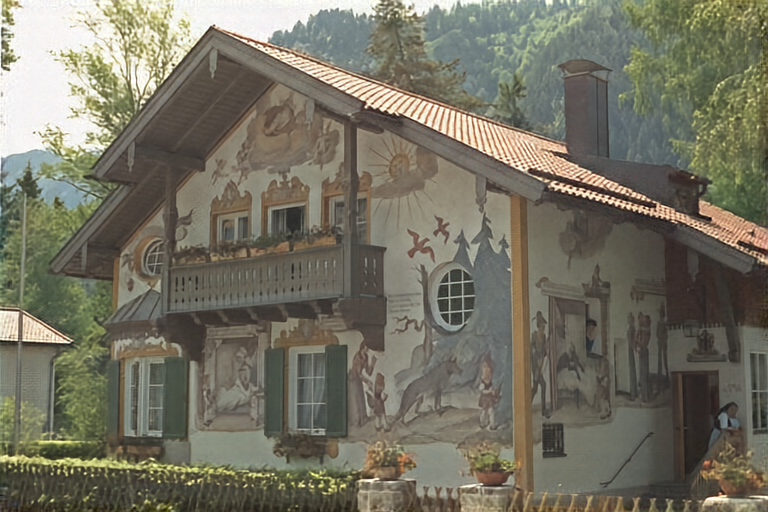

analysis: median=30.63ms, mean=101.68ms, throughput=12.84 MP/s
transfer: median=0.52ms, mean=0.53ms, throughput=750.91 MP/s
store: median=3.64ms, mean=4.40ms, throughput=107.90 MP/s
load: median=3.56ms, mean=4.67ms, throughput=110.37 MP/s
synthesis: median=26.47ms, mean=189.01ms, throughput=14.86 MP/s


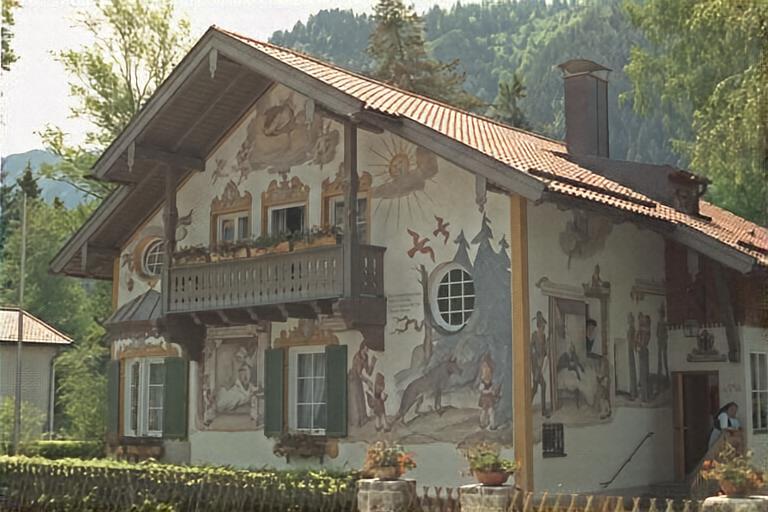

analysis: median=75.88ms, mean=77.19ms, throughput=5.18 MP/s
transfer: median=0.01ms, mean=0.01ms, throughput=60494.78 MP/s
store: median=3.34ms, mean=3.83ms, throughput=117.64 MP/s
load: median=3.15ms, mean=3.89ms, throughput=124.90 MP/s
synthesis: median=1073.60ms, mean=1091.44ms, throughput=0.37 MP/s


In [2]:
for device in ['xpu','cpu']:
    wallclock.reset()
    codec.to(device)
    
    for sample in dataset['validation']:
        
        img = sample['image']
        x = pil_to_tensor(img).unsqueeze(0).to(dtype) / 127.5 - 1.0
        x = x.to(device)
    
        with wallclock('analysis'):
            with torch.inference_mode():
                x = codec.wpt(x)
                x = 12.8 * compand(x, power=0.4)
                x = x.to(device)
                x = codec.encoder_blocks(x)
                x = codec.conv_down(x)
                x = codec.quantize.compand(x)
                
        with wallclock('transfer'):
            x = x.cpu()
            
        with wallclock('store'):
            x = latent_to_pil(x, n_bits=8, C=3)[0]
            buff = io.BytesIO()
            x.save(buff, format='JPEG-LS', near_lossless=0)
            
        with wallclock('load'):
            x = pil_to_latent([PIL.Image.open(buff)], N=config.latent_dim, n_bits=8, C=3).to(device).to(dtype)        
    
        with wallclock('synthesis'):
            x = x.to(device)
            with torch.inference_mode():
                x = codec.decode(x).clamp(-1,1)
            
    display(to_pil_image(x[0]/2+0.5))
    wallclock.summary(pixels=512*768)